# Implémentation inspiré de l'article originale

Pseudo code de PPO:

Pour iteration=1,2, ... faire <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ Pour acteur=1,2,...,N faire <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\textrm{   }\textrm{   }\textrm{   }\textrm{   }$  Faire tourner la politique $\pi_{\theta_{old}}$ pour $T$ timesteps <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\textrm{   }\textrm{   }\textrm{   }\textrm{   }$  Calculer l'avantage estimé $\hat{A}_{1}, ..., \hat{A}_{T}$ <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ **fin pour** <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ Optimizer $L$ par rapport à $\theta$, pendant $K$ epochs pour un minibatch de taille $M \leq NT$ <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\theta_{old} := \theta$ <br>
**fin pour**

Avec :
* $L = \mathbb{E}[L^{CLIP} - c1L^{VF} + c2S[\pi_{\theta}(s_{t})]]$
* $L^{CLIP} = min(r_{t}\hat{A}_{t}, clip(r_{t}), 1-\epsilon, 1+\epsilon)\hat{A}_{t}$ : permet de mettre à jour les poids de la politique petit à petit, $\epsilon$ étant un nombre petit
* $ L^{VF} = MSE(A_{t}, \hat{A}_{t})$ : met à jour le critic
* $S[\pi_{\theta}(s_{t})]$ : un bonus d'entropy

Pseudo code de [Schulman et. alii.](https://arxiv.org/pdf/1707.06347.pdf)

## Import de librairie

In [1]:
import gymnasium as gym

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, Dataset

from random import shuffle

import numpy as np

import matplotlib.pyplot as plt

## Définition des models

Modèle utilisé par le critic

In [2]:
class Regressor(nn.Module):
    def __init__(self, inChannel:int, outChannel:int):
        super().__init__()
        self.inLayer = nn.Sequential(
            nn.Linear(inChannel, 32),
            nn.Tanh()
        )
        self.outLayer = nn.Sequential(
            nn.Linear(32, outChannel)
        )
    def forward(self, x):
        x = self.inLayer(x.float())
        return self.outLayer(x)

Modèle utilisé pour l'acteur, génère les paramètres de la distribution à utiliser pour choisir l'action

In [3]:
class NormalDistribParam(nn.Module):
    def __init__(self, inChannel):
        super().__init__()
        self.inLayer = nn.Sequential(
            nn.Linear(inChannel, 32),
            nn.Tanh()
        )
        self.muLayer = nn.Sequential(
            nn.Linear(32, 1),
        )
        self.sigmaLayer = nn.Sequential(
            nn.Linear(32, 1),
        )
    def forward(self, x):
        x = self.inLayer(x.float())
        return self.muLayer(x),torch.log(1+torch.exp(self.sigmaLayer(x)))

Définition de l'acteur qui décidera de l'action à prendre en fonction de la *policy* aprise ainsi que le critic qui évalura la qualité de la décision prise.


In [4]:

class Policy():
    def __init__(self, dim_state:int, lr=1e-2):
        self.lr = lr
        self.reg = NormalDistribParam(inChannel=dim_state) 
        self.optim = torch.optim.Adam(self.reg.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=.9)

class Critic():
    def __init__(self, dim_state:int, lr=1e-3):
        self.lr = lr
        self.reg = Regressor(inChannel = dim_state, outChannel = 1)
        self.optim = torch.optim.Adam(self.reg.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=.9)

## Définition des fonctions utiles

Choisi une action et l'évalue, utilisé pour générer les données d'entrainement

In [5]:
def choose_action(policy, critic, state):
    try:
        state = torch.from_numpy(state)
    except:
        state = torch.tensor(list(state))
    
    mean, std = policy.reg(state)
    
    distrib = Normal(mean+1e-5, std+1e-5)

    action = distrib.sample()
    p = distrib.log_prob(action)
    v = critic.reg(state)

    return action.detach(), p.detach(), v.detach()

Utilisé lors de la phase d'apprentissage, retourne les données à optimiser

In [6]:
def evaluate(policy, critic, state, action):
    
    mean, std = policy.reg(state)
    
    distrib = Normal(mean+1e-5, std+1e-5)

    p = distrib.log_prob(action)
    v = critic.reg(state)
    entropy = distrib.entropy()

    return p, v, entropy

évalue la policy aprise, retourne les résultats moyennés sur n jeux

In [7]:
def test_policy(env, policy, critic, n):
    n_iter = 0
    r = 0
    for _ in range(n):
        term, trunc = False, False

        state, _ = env.reset()

        while (not term or trunc):
            action, _, _ = choose_action(policy, critic, state)

            state, reward, term, trunc, _ = env.step(action)

            n_iter += 1
            r += reward
    return n_iter/n, r/n

## Initialisation des données d'entrainement

### Constantes

In [ ]:
# Le nombre de fois où la boucle d'entrainement est répété
iterations = 50 
# Nombre d'épisode à jouer
N = 100
# mis à jour à chaque boucle, doit être inférieur à la longueur de l'épisode
T = 3
# Le nombre d'epochs à effectuer pour chaque itération
epochs = 10

# Utilisé pour mettre à jour T pendant l'exécution
n_iter = 0

# Discount factor
gamma = .95
# clip variable
epsilon = .2
# Le pourçentage de segment (état_n, action_n, reward_n, état_n+1) à utilisé pour l'apprentissage
percent = .50

# c1 : variable de pondération du critic dans le Loss
# c2 : variable de pondération du bonus d'entropy dans le Loss
c1, c2 = .01,0.0001

# Nom de l'environnement à utiliser
# env_name = "InvertedPendulum-v4"
env_name = "InvertedDoublePendulum-v4"

### Création de l'environnement

In [9]:

env = gym.make(env_name)

policy = Policy(dim_state=env.observation_space.shape[0])
critic = Critic(dim_state=env.observation_space.shape[0])

mse = nn.MSELoss()

A exécuter pour charger les poids des models pré-entrainer

In [30]:
ckp_pol = torch.load("model-ppo/from-paper/"+env_name+"_pol.pt")
policy.reg.load_state_dict(ckp_pol["model"])

ckp_critic = torch.load("model-ppo/from-paper/"+env_name+"_critic.pt")
critic.reg.load_state_dict(ckp_critic["model"])

<All keys matched successfully>

## Définition du *custom Dataset* de pytorch

L'utilisation d'un Dataset et Dataloader permet l'apprentissage en batch de manière très simple

### Constantes pour séparer les données de l'apprentissage

In [10]:
STATE_IDX_LOW = 0
STATE_IDX_UP = env.observation_space.shape[0]
ACTION_IDX = STATE_IDX_UP
ADV_IDX = 1 + STATE_IDX_UP
P_IDX = 2 + STATE_IDX_UP
V_IDX = 3 + STATE_IDX_UP

print(STATE_IDX_LOW, STATE_IDX_UP, ACTION_IDX, ADV_IDX, P_IDX, V_IDX)

0 11 11 12 13 14


### Torch Dataset

In [11]:
class SegmentDataset(Dataset):
    def __init__(self, data:list, partition:float):
      self.data = torch.cat(data[:int(len(data)*partition)], dim=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        old_state = self.data[idx][STATE_IDX_LOW : STATE_IDX_UP]
        old_action = self.data[idx][ACTION_IDX]
        old_adv = self.data[idx][ADV_IDX]
        old_p = self.data[idx][P_IDX]
        old_V = self.data[idx][V_IDX]

        return old_state, old_action, old_adv, old_p, old_V

## Apprentissage

Iter[0/50]  n_iter mean : 6.5 reward mean : 59.264964115562826
Iter[1/50]  n_iter mean : 6.45 reward mean : 58.79502356731541
Iter[2/50]  n_iter mean : 6.6 reward mean : 60.19859701664001
Iter[3/50]  n_iter mean : 6.95 reward mean : 63.41026135811906
Iter[4/50]  n_iter mean : 6.85 reward mean : 62.536077343138764
Iter[5/50]  n_iter mean : 6.3 reward mean : 57.29085531231849
Iter[6/50]  n_iter mean : 6.65 reward mean : 60.655724538277255
Iter[7/50]  n_iter mean : 6.6 reward mean : 60.07834744250961
Iter[8/50]  n_iter mean : 7.5 reward mean : 68.47072239522328
Iter[9/50]  n_iter mean : 8.05 reward mean : 73.71356051632702
Iter[10/50]  n_iter mean : 6.9 reward mean : 62.94176389800663
Iter[11/50]  n_iter mean : 7.35 reward mean : 67.04946360823382
Iter[12/50]  n_iter mean : 7.2 reward mean : 65.78520282057913
Iter[13/50]  n_iter mean : 8.25 reward mean : 75.44180678574615
Iter[14/50]  n_iter mean : 8.25 reward mean : 75.57414882065633
Iter[15/50]  n_iter mean : 7.95 reward mean : 72.77644

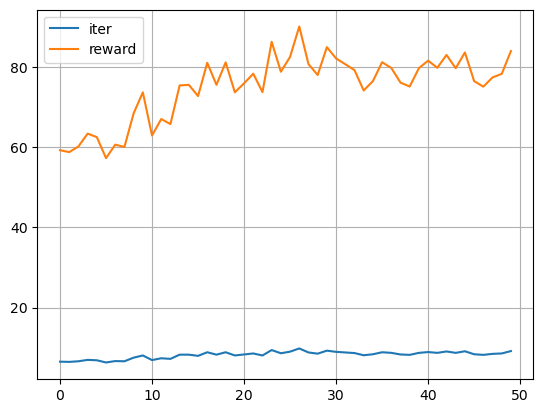

In [12]:
graph_r = []
graph_iter = []
for iteration in range(iterations):

    old_buff = []
    
    for n_actor in range(N):

        t_t = []
        t_V = []
        t_adv = []
        t_reward = []

        t_buff = []

        term = True
        trunc = True
        t = 0
        # échantillonnage
        for timesteps in range(int(max(T, n_iter-1))):
            t += 1
            if term or trunc: # si l'environnement est mort, le redémarrer
                t = 0
                state, _ = env.reset()

            action, p, v = choose_action(policy, critic, state)
            state, reward, term, trunc, _ = env.step(action)

            t_reward.append(reward)

            t_t.append(t)
            # calcul de la state action function
            t_V.append(sum([t_reward[j]*gamma**j for j in range(timesteps-t+1, timesteps+1)]))
            # calcul de l'avantage
            t_adv.append(t_V[-1]-v)

            state = tuple(state)
            
            t_buff.append([*state, action, t_V[-1]-v, p, t_V[-1]])


        old_buff.append(torch.tensor(t_buff, dtype=torch.float32))

    # mélange l'ordre des segments
    shuffle(old_buff)

    train_data = SegmentDataset(old_buff, percent)
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
    
    # Boucle d'apprentissage
    for epoch in range(epochs):
        avg_loss = 0
        for old_state, old_action, old_adv, old_p, old_V in train_dataloader:

            newP, newV, entropy = evaluate(policy, critic, old_state, old_action)

            ratio = torch.exp(newP - old_p)

            loss1 = ratio * old_adv
            loss2 = torch.clamp(ratio, 1-epsilon, 1+epsilon)*old_adv

            l_clip = torch.min(loss1, loss2)
            
            old_V = torch.unsqueeze(old_V, dim=1)
            l_vf = mse(newV, old_V)

            loss = -(l_clip - c1*l_vf + c2*entropy)
            loss = loss.mean()
            policy.optim.zero_grad()
            critic.optim.zero_grad()
            loss.backward()
            policy.optim.step()
            critic.optim.step()
            
            avg_loss += loss.detach()
        # print(f'Epoch [{epoch}/{epochs}] Mean Loss {avg_loss/(int(N*T*percent))}')

    n_iter, r = test_policy(env, policy, critic, 20)
    graph_iter.append(n_iter)
    graph_r.append(r)
    print(f"Iter[{iteration}/{iterations}]  n_iter mean : {n_iter} reward mean : {r}")
    if iteration != 0 and iteration%10:
        policy.scheduler.step()
        critic.scheduler.step()

torch.save({"model":policy.reg.state_dict()}, "model-ppo/from-paper/"+env_name+"_pol.pt")
torch.save({"model":critic.reg.state_dict()}, "model-ppo/from-paper/"+env_name+"_critic.pt")
plt.figure()
plt.plot(graph_iter)
plt.plot(graph_r)
plt.grid()
plt.legend(["iter", "reward"])

Evaluation des résultats

In [13]:
n_iter, r = test_policy(env, policy, critic, 20)
print(n_iter, r)

8.3 76.02782007315837


Même si le nombre de moyen de *steps* par épisodes n'augmente pas beaucoup, les  récompenses moyennes continue d'augmenter, le réseaux apprend bien quelque chose.

# [Comparaison avec le tutoriel de Pythorch](https://pytorch.org/rl/tutorials/coding_ppo.html)

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

## Define Hyperparameters

In [2]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

/tmp/ipykernel_2031437/501024724.py:1: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  device = "cpu" if not torch.has_cuda else "cuda:0"


## Data collection parameters

In [3]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 20_000 // frame_skip

## PPO parameters

In [4]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

## Define an environment

In [5]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

/home/etu/noiraula/PE//lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/etu/noiraula/PE//lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(


## Normalisation

In [6]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(
            in_keys=["observation"],
        ),
        StepCounter(),
    ),
)

In [7]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [8]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [9]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("done_spec:", env.done_spec)
print("action_spec:", env.action_spec)
print("state_spec:", env.state_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([11]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32,
    domain=continuous)
done_spec: CompositeSp

In [10]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),


## Policy

In [11]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

/home/etu/noiraula/PE//lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [13]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

## Value network

In [14]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [15]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

## Data collector

In [16]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

## Replay buffer

In [17]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

## Loss function

In [18]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

## Training loop

In [19]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

eval cumulative reward:  249.5341 (init:  92.3797), eval step-count: 26, average reward= 9.2845 (init= 9.0848), step count (max): 58, lr policy:  0.0000: 100%|██████████| 20000/20000 [04:07<00:00, 80.84it/s]

## Result

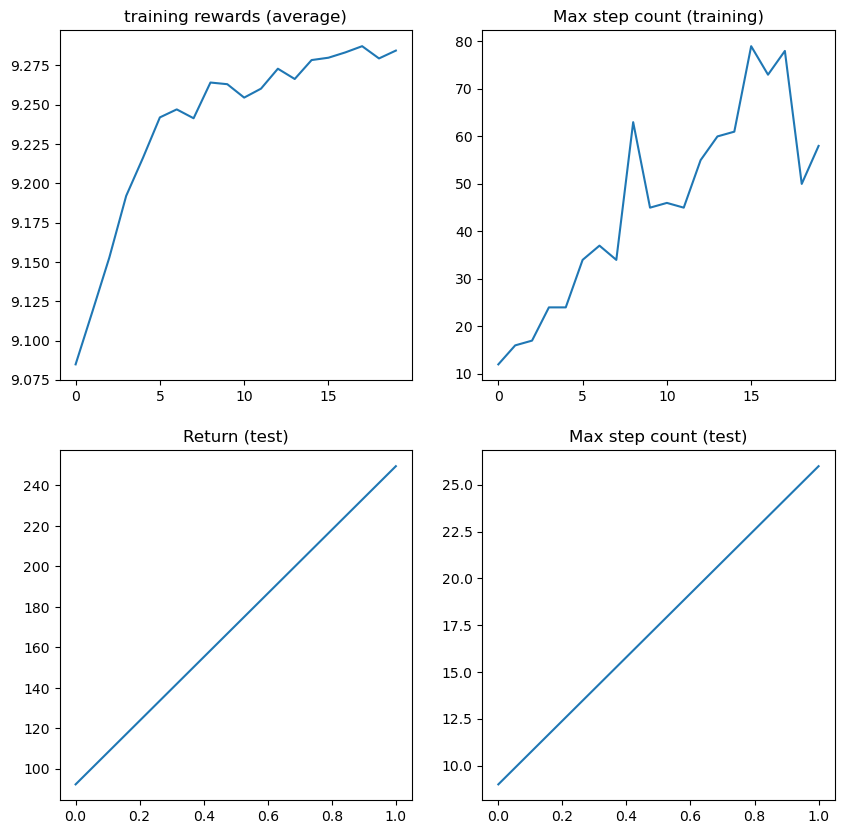

eval cumulative reward:  249.5341 (init:  92.3797), eval step-count: 26, average reward= 9.2845 (init= 9.0848), step count (max): 58, lr policy:  0.0000: 100%|██████████| 20000/20000 [04:20<00:00, 80.84it/s]

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

# Conclusion

L'implémentation originale fonctionne globalement moin bien que la version proposé par Pytorch. La version de Pytorch fonctionne extrement bien pour le simple pendule (voir `image/torch-simple_pendulum.png`), le nombre de *step* atteint est proche de 1000 ce qui est proche du maximal prévu par l'envronnement. Le double pendule fonctionne beaucoup moin bien, même si la récompense continue d'augmenter pour atteindre les 90, le nombre de *step* atteint est d'environ 20 (voir `image/torch-double_pendulum.png`) ce qui à peinne plus que l'implémentation précédente (voir `image/paper-double_pendulum.png`)


Les pauvres résultats de la première implémentation sont relativement décevant, ils sont moins bons que ceux obtenue avec REINFORCE alors que PPO est cencé être une version amélioré de cette algorithme. Ces résultats peuvent être due à plusieurs facteurs, de mauvais hyper-paramètres.